In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from skmultiflow.trees import HoeffdingTree
from sklearn import metrics
import matplotlib.pyplot as plt
import re

In [3]:
# all_news_tsv = "D:/Dataset/Fake_News_Dataset_Tamil/tam_off_test_withlabels.tsv"
# all_news_csv = "D:/Dataset/Fake_News_Dataset_Tamil/tam_off_test.csv"
# with open(all_news_tsv, 'r') as myfile:  
#   with open(all_news, 'w') as csv_file:
#     for line in myfile:
       
#       # Replace every tab with comma
#       fileContent = re.sub("\t", ",", line)
       
#       # Writing into csv file
#       csv_file.write(fileContent)

# csv_table=pd.read_table(all_news_tsv,sep='\t')
 
# converting tsv file into csv
# csv_table.to_csv(all_news_csv,index=False)
 

In [4]:
# Load and preprocess data
all_news = "D:/Dataset/Fake_News_Dataset_Tamil/tam_off_train_csv.csv"
all_df = pd.read_csv(all_news)
true_df = all_df[all_df["Category"] == "OFF"]

fake_df = all_df[all_df["Category"] == "NOT"]

In [5]:
true_df["label"] = 1  # 1 for true news
fake_df["label"] = 0  # 0 for fake news
combined_df = pd.concat([true_df, fake_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=43).reset_index(drop=True)

C:\Users\Kartik Gounder\AppData\Local\Temp\ipykernel_9776\3389176192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df["label"] = 1  # 1 for true news
C:\Users\Kartik Gounder\AppData\Local\Temp\ipykernel_9776\3389176192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df["label"] = 0  # 0 for fake news


In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=43)

In [7]:
y_test

376     1
777     1
2012    1
309     0
3276    0
       ..
1879    1
1648    0
3474    1
3675    1
1200    1
Name: label, Length: 800, dtype: int64

In [8]:
type(y_test)

pandas.core.series.Series

In [9]:
type(combined_df)

pandas.core.frame.DataFrame

In [10]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [11]:
# Train Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(random_state=42)
pac.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(random_state=42)

In [12]:
# Train SGD Classifier
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(X_train_tfidf, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [13]:
# Train Hoeffding Tree classifier incrementally
ht = HoeffdingTree()
for i in range(len(combined_df)):
    text = combined_df.loc[i, 'Text']
    label = combined_df.loc[i, 'label']
    X_partial = vectorizer.transform([text]).toarray()[0]
    ht.partial_fit([X_partial], [int(label)])

c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\trees\hoeffding_tree.py:32: FutureWarning: 'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.
The old name will be removed in v0.7.0
  warnings.warn("'HoeffdingTree' has been renamed to 'HoeffdingTreeClassifier' in v0.5.0.\n"
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: overflow encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(
c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\bayes\utils.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  tmp = votes[class_index] * obs.probability_of_attribute_value_given_class(


In [14]:
# Get predictions
pac_pred = pac.predict(X_test_tfidf)
sgd_pred = sgd.predict(X_test_tfidf)
ht_pred = ht.predict(X_test_tfidf.toarray())

c:\Users\Kartik Gounder\Desktop\Projects\.venv\Lib\site-packages\skmultiflow\utils\utils.py:62: RuntimeWarning: invalid value encountered in scalar divide
  dictionary[key] = value / factor


In [15]:
# Concatenate predictions as features
X_test_features = pd.DataFrame({'PAC': pac_pred, 'SGD': sgd_pred, 'HT' :  ht_pred})

In [16]:
# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_test_features, y_test)

GradientBoostingClassifier()

In [17]:
# Get final predictions
final_pred = gb.predict(X_test_features)

In [18]:
# Calculate accuracy
accuracy = accuracy_score(y_test, final_pred)
print("Final accuracy:", accuracy)

Final accuracy: 0.87375


In [19]:
accuracy = accuracy_score(y_test, pac_pred)
print("Final accuracy PAC:", accuracy)
accuracy = accuracy_score(y_test, ht_pred)
print("Final accuracy HC:", accuracy)
accuracy = accuracy_score(y_test, sgd_pred)
print("Final accuracy SDG:", accuracy)

Final accuracy PAC: 0.85875
Final accuracy HC: 0.57125
Final accuracy SDG: 0.86625


In [20]:
# Print confusion matrices
print("Confusion Matrix for PAC:")
print(confusion_matrix(y_test, pac_pred))
print()

print("Confusion Matrix for SGD:")
print(confusion_matrix(y_test, sgd_pred))
print()

print("Confusion Matrix for HT:")
print(confusion_matrix(y_test, ht_pred))
print()

print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test, final_pred))
print()

Confusion Matrix for PAC:
[[353  57]
 [ 56 334]]

Confusion Matrix for SGD:
[[361  49]
 [ 58 332]]

Confusion Matrix for HT:
[[403   7]
 [336  54]]

Confusion Matrix for Gradient Boosting Classifier:
[[364  46]
 [ 55 335]]



In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [22]:
confusion_matrix = metrics.confusion_matrix(y_test, final_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

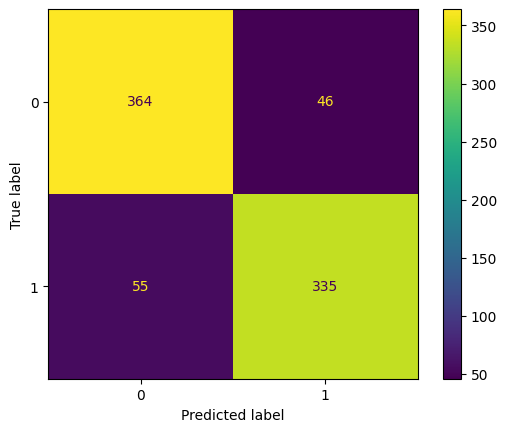

In [23]:
cm_display.plot()
plt.show()

In [24]:
Accuracy = metrics.accuracy_score(y_test, final_pred)
Precision = metrics.precision_score(y_test, final_pred)
Sensitivity_recall = metrics.recall_score(y_test, final_pred)
Specificity = metrics.recall_score(y_test, final_pred, pos_label=0)
F1_score = metrics.f1_score(y_test, final_pred)
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.87375, 'Precision': 0.8792650918635171, 'Sensitivity_recall': 0.8589743589743589, 'Specificity': 0.8878048780487805, 'F1_score': 0.8690012970168612}


In [25]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [26]:
# Calculate precision, recall, and F1-score for PAC
pac_precision, pac_recall, pac_f1, _ = precision_recall_fscore_support(y_test, pac_pred, average='binary')

# Calculate precision, recall, and F1-score for SGD
sgd_precision, sgd_recall, sgd_f1, _ = precision_recall_fscore_support(y_test, sgd_pred, average='binary')

# Calculate precision, recall, and F1-score for Hoeffding Tree
ht_precision, ht_recall, ht_f1, _ = precision_recall_fscore_support(y_test, ht_pred, average='binary')

# Calculate precision, recall, and F1-score for Gradient Boosting
gb_precision, gb_recall, gb_f1, _ = precision_recall_fscore_support(y_test, final_pred, average='binary')

# Calculate accuracy for PAC, SGD, HT, and Gradient Boosting
pac_accuracy = accuracy_score(y_test, pac_pred)
sgd_accuracy = accuracy_score(y_test, sgd_pred)
ht_accuracy = accuracy_score(y_test, ht_pred)
gb_accuracy = accuracy_score(y_test, final_pred)

# Confusion matrices
pac_conf_matrix = confusion_matrix(y_test, pac_pred)
sgd_conf_matrix = confusion_matrix(y_test, sgd_pred)
ht_conf_matrix = confusion_matrix(y_test, ht_pred)
gb_conf_matrix = confusion_matrix(y_test, final_pred)

# Display results in a structured format
print("Classifier\t\tAccuracy\tPrecision\tRecall\t\tF1-Score")
print("PAC\t\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(pac_accuracy, pac_precision, pac_recall, pac_f1))
print("SGD\t\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(sgd_accuracy, sgd_precision, sgd_recall, sgd_f1))
print("Hoeffding Tree\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(ht_accuracy, ht_precision, ht_recall, ht_f1))
print("Gradient Boosting\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(gb_accuracy, gb_precision, gb_recall, gb_f1))

# Display confusion matrices
print("\nConfusion Matrix for PAC:")
print(pac_conf_matrix)
print("\nConfusion Matrix for SGD:")
print(sgd_conf_matrix)
print("\nConfusion Matrix for Hoeffding Tree:")
print(ht_conf_matrix)
print("\nConfusion Matrix for Gradient Boosting:")
print(gb_conf_matrix)

Classifier		Accuracy	Precision	Recall		F1-Score
PAC			0.8588		0.8542		0.8564		0.8553
SGD			0.8662		0.8714		0.8513		0.8612
Hoeffding Tree		0.5713		0.8852		0.1385		0.2395
Gradient Boosting	0.8738		0.8793		0.8590		0.8690

Confusion Matrix for PAC:
[[353  57]
 [ 56 334]]

Confusion Matrix for SGD:
[[361  49]
 [ 58 332]]

Confusion Matrix for Hoeffding Tree:
[[403   7]
 [336  54]]

Confusion Matrix for Gradient Boosting:
[[364  46]
 [ 55 335]]
